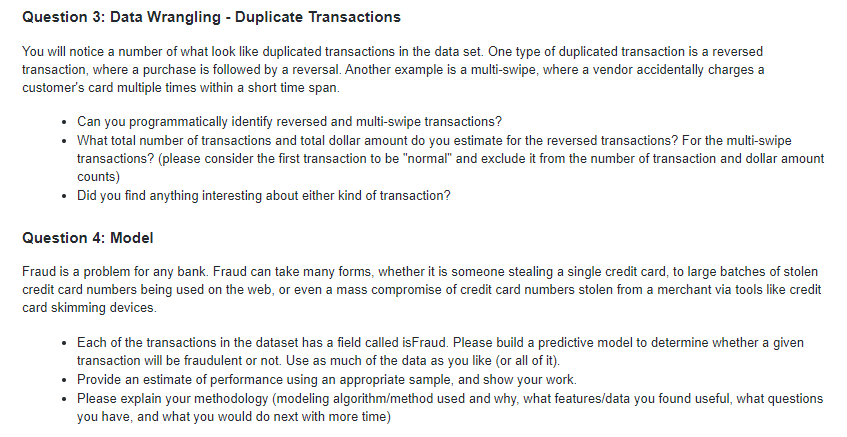

In [1]:
#pip install imblearn

In [2]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = None
pd.options.display.max_rows = 50
from datetime import datetime as dt

from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold

data = pd.read_json('transactions.txt',lines=True)
data['transactionDateTime'] = pd.to_datetime(data['transactionDateTime'])
data['accountOpenDate']=pd.to_datetime(data['accountOpenDate'])                                                                       

data.replace('',np.nan,inplace=True)
data.drop(['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip','posOnPremises','recurringAuthInd','accountNumber'],axis=1,inplace=True)

In [3]:
data.head()

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False
1,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False
2,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
3,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
4,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,True,False,False


In [4]:
print(data.isnull().sum())

customerId                     0
creditLimit                    0
availableMoney                 0
transactionDateTime            0
transactionAmount              0
merchantName                   0
acqCountry                  4562
merchantCountryCode          724
posEntryMode                4054
posConditionCode             409
merchantCategoryCode           0
currentExpDate                 0
accountOpenDate                0
dateOfLastAddressChange        0
cardCVV                        0
enteredCVV                     0
cardLast4Digits                0
transactionType              698
currentBalance                 0
cardPresent                    0
expirationDateKeyInMatch       0
isFraud                        0
dtype: int64


In [5]:
data[data['isFraud']==True].isnull().sum()

customerId                    0
creditLimit                   0
availableMoney                0
transactionDateTime           0
transactionAmount             0
merchantName                  0
acqCountry                  149
merchantCountryCode          82
posEntryMode                269
posConditionCode             22
merchantCategoryCode          0
currentExpDate                0
accountOpenDate               0
dateOfLastAddressChange       0
cardCVV                       0
enteredCVV                    0
cardLast4Digits               0
transactionType              14
currentBalance                0
cardPresent                   0
expirationDateKeyInMatch      0
isFraud                       0
dtype: int64

<AxesSubplot:ylabel='transactionType'>

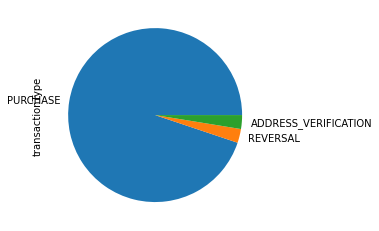

In [6]:
data['transactionType'].value_counts().plot(kind='pie')

In [7]:
data.loc[(data["isFraud"] == True)&(data['transactionType'].isnull()),'transactionType']='PURCHASE'

In [8]:
data[data['isFraud']==True][['acqCountry','merchantCountryCode']].value_counts()

acqCountry  merchantCountryCode
US          US                     12122
MEX         MEX                       64
CAN         CAN                       55
PR          PR                        27
dtype: int64

In [9]:
data[data['isFraud']==True][['acqCountry','merchantCountryCode']].isnull().value_counts()

acqCountry  merchantCountryCode
False       False                  12268
True        True                      82
            False                     67
dtype: int64

In [10]:
data['acqCountry']= np.where((data['acqCountry'].isnull())&(data['isFraud']==True), 
                             data['merchantCountryCode'], data['acqCountry'])

In [11]:
data[data['isFraud']==True].isnull().sum()

customerId                    0
creditLimit                   0
availableMoney                0
transactionDateTime           0
transactionAmount             0
merchantName                  0
acqCountry                   82
merchantCountryCode          82
posEntryMode                269
posConditionCode             22
merchantCategoryCode          0
currentExpDate                0
accountOpenDate               0
dateOfLastAddressChange       0
cardCVV                       0
enteredCVV                    0
cardLast4Digits               0
transactionType               0
currentBalance                0
cardPresent                   0
expirationDateKeyInMatch      0
isFraud                       0
dtype: int64

In [12]:
print(data['acqCountry'].value_counts())
print(data['merchantCountryCode'].value_counts())

US     774775
MEX      3130
CAN      2425
PR       1538
Name: acqCountry, dtype: int64
US     778511
MEX      3143
CAN      2426
PR       1559
Name: merchantCountryCode, dtype: int64


In [13]:
data.loc[(data["isFraud"] == True)&(data['acqCountry'].isnull()),'acqCountry']='US'
data.loc[(data["isFraud"] == True)&(data['merchantCountryCode'].isnull()),'merchantCountryCode']='US'
data[data['isFraud']==True].isnull().sum()

customerId                    0
creditLimit                   0
availableMoney                0
transactionDateTime           0
transactionAmount             0
merchantName                  0
acqCountry                    0
merchantCountryCode           0
posEntryMode                269
posConditionCode             22
merchantCategoryCode          0
currentExpDate                0
accountOpenDate               0
dateOfLastAddressChange       0
cardCVV                       0
enteredCVV                    0
cardLast4Digits               0
transactionType               0
currentBalance                0
cardPresent                   0
expirationDateKeyInMatch      0
isFraud                       0
dtype: int64

In [14]:
print(data[data['isFraud']==True]['posConditionCode'].value_counts().to_frame())
print(data['posConditionCode'].value_counts().to_frame())

    posConditionCode
01             10230
08              1936
99               229
    posConditionCode
01            628787
08            149634
99              7533


In [15]:
data.loc[(data["isFraud"] == True)&(data['posConditionCode'].isnull()),'posConditionCode']='01'

In [16]:
print(data[data['isFraud']==True][['posEntryMode']].value_counts().to_frame())

                 0
posEntryMode      
09            5659
02            3421
05            2456
90             372
80             240


In [17]:
print(data['posEntryMode'].value_counts().to_frame())

    posEntryMode
05        315035
09        236481
02        195934
90         19576
80         15283


In [18]:
data[data['isFraud']==True][['merchantCategoryCode']].value_counts()

merchantCategoryCode
online_retail           4938
online_gifts            1606
rideshare               1272
fastfood                1074
food                    1014
entertainment            961
airline                  534
auto                     273
hotels                   250
subscriptions            216
furniture                103
health                    90
personal care             86
dtype: int64

In [19]:
data.loc[(data["isFraud"] == True)&(data['posEntryMode'].isnull()),'posEntryMode']='09'

In [20]:
data[data['isFraud']==True].isnull().sum()

customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
currentBalance              0
cardPresent                 0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64

In [21]:
data.dropna(inplace=True)

In [22]:
data.isnull().sum()

customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
currentBalance              0
cardPresent                 0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64

In [23]:
print(len(data[data['isFraud']==True]),len(data))

12417 777119


In [24]:
data.columns

Index(['customerId', 'creditLimit', 'availableMoney', 'transactionDateTime',
       'transactionAmount', 'merchantName', 'acqCountry',
       'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'isFraud'],
      dtype='object')

In [25]:
reversal_transaction = data[data['transactionType']=='REVERSAL']
len(reversal_transaction)

20075

In [26]:
data['multiswap'] = (data.sort_values(['transactionDateTime'])
                    .groupby(['customerId', 'creditLimit',  'transactionAmount', 'merchantName',
                              'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
                              'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
                              'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
                              'transactionType', 'cardPresent',
                              'expirationDateKeyInMatch'],sort=False)['transactionDateTime'].diff().dt.total_seconds().lt(300))

In [27]:
data['multiswap'].value_counts()

False    769560
True       7559
Name: multiswap, dtype: int64

In [28]:
len(data[(data['multiswap']==False)&(data['transactionType']=='REVERSAL')])

20075

In [29]:
data.drop(data[data['multiswap']==True].index, inplace = True)

In [30]:
len(data)

769560

In [31]:
data = data.merge(reversal_transaction,on=['customerId', 'creditLimit', 'transactionAmount', 'merchantName',
                    'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode','dateOfLastAddressChange','cardPresent',
                   'merchantCategoryCode', 'currentExpDate', 'accountOpenDate', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
                   'expirationDateKeyInMatch','isFraud'],how='left',suffixes=("","_Y"))

In [32]:
data.columns

Index(['customerId', 'creditLimit', 'availableMoney', 'transactionDateTime',
       'transactionAmount', 'merchantName', 'acqCountry',
       'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'isFraud', 'multiswap', 'availableMoney_Y',
       'transactionDateTime_Y', 'transactionType_Y', 'currentBalance_Y'],
      dtype='object')

In [33]:
data.drop(data[data['transactionType']==data['transactionType_Y']].index,inplace=True)

In [34]:
data['transactionType'].value_counts()

PURCHASE                729731
ADDRESS_VERIFICATION     19754
Name: transactionType, dtype: int64

In [35]:
data['transactionType_Y'].value_counts()

REVERSAL    15805
Name: transactionType_Y, dtype: int64

In [36]:
data['reversed'] = np.where(data['transactionType_Y']=='REVERSAL',1,0)

In [37]:
data.columns

Index(['customerId', 'creditLimit', 'availableMoney', 'transactionDateTime',
       'transactionAmount', 'merchantName', 'acqCountry',
       'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'isFraud', 'multiswap', 'availableMoney_Y',
       'transactionDateTime_Y', 'transactionType_Y', 'currentBalance_Y',
       'reversed'],
      dtype='object')

In [38]:
data.drop(['availableMoney_Y','transactionDateTime_Y', 'transactionType_Y', 'currentBalance_Y'],axis=1,inplace=True)

In [39]:
data = data.astype({'cardPresent': int, 'expirationDateKeyInMatch': int,
                   'isFraud': int, 'multiswap': int})  

In [40]:
data['cvvmatch'] = np.where(data['cardCVV']==data['enteredCVV'],1,0)

In [41]:
data[data['isFraud']==True]['cvvmatch'].value_counts()

1    11759
0      193
Name: cvvmatch, dtype: int64

In [42]:
data.head()

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,multiswap,reversed,cvvmatch
0,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,0,0,0,0,0,1
1,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,1,0,0,0,0,1
2,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0,0,0,1
3,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0,0,0,1
4,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,1,0,0,0,0,1


In [43]:
data['merchantCategoryCode'].value_counts().sort_values()

cable/phone               1350
gym                       2183
food_delivery             6000
furniture                 7081
online_subscriptions     10928
airline                  14604
mobileapps               14787
personal care            18002
health                   18141
auto                     20564
subscriptions            21796
fuel                     23631
hotels                   32341
rideshare                48669
online_gifts             62987
food                     71633
entertainment            76083
fastfood                106490
online_retail           192215
Name: merchantCategoryCode, dtype: int64

In [44]:
data.head()

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,multiswap,reversed,cvvmatch
0,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,0,0,0,0,0,1
1,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,1,0,0,0,0,1
2,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0,0,0,1
3,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0,0,0,1
4,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,1,0,0,0,0,1


<AxesSubplot:ylabel='Frequency'>

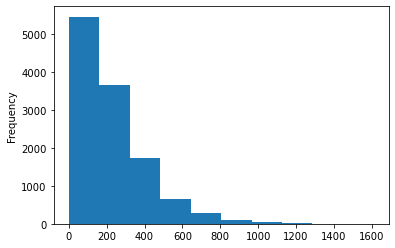

In [45]:
data[data['isFraud']==True]['transactionAmount'].plot(kind='hist')

In [46]:
data[(data['currentBalance']==0)][['creditLimit','availableMoney','transactionDateTime','transactionAmount','currentBalance']].head()

,creditLimit,availableMoney,transactionDateTime,transactionAmount,currentBalance
0,5000,5000.0,2016-08-13 14:27:32,98.55,0.0
1,5000,5000.0,2016-10-11 05:05:54,74.51,0.0
2,5000,5000.0,2016-11-08 09:18:39,7.47,0.0
3,5000,5000.0,2016-12-10 02:14:50,7.47,0.0
4,5000,5000.0,2016-03-24 21:04:46,71.18,0.0


In [47]:
data.columns

Index(['customerId', 'creditLimit', 'availableMoney', 'transactionDateTime',
       'transactionAmount', 'merchantName', 'acqCountry',
       'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'isFraud', 'multiswap', 'reversed',
       'cvvmatch'],
      dtype='object')

In [48]:
data['creditLimit_q']= pd.qcut(data['creditLimit'],q=4,
                               labels=["q1", "q2", "q3",'q4'])

In [49]:
data['creditLimit_q'].value_counts()

q1    357417
q3    186774
q4    111813
q2     93481
Name: creditLimit_q, dtype: int64

In [50]:
data['transactionAmount_q']= pd.qcut(data['transactionAmount'],q=6,
                                    labels=["q1", "q2", "q3",
                                            'q4',"q5", "q6"])

In [51]:
data['transactionAmount_q'].value_counts()

q1    124925
q3    124917
q2    124916
q6    124913
q4    124910
q5    124904
Name: transactionAmount_q, dtype: int64

In [52]:
pd.qcut(data['transactionAmount'],q=6).cat.categories.values

<IntervalArray>
[(-0.001, 19.33], (19.33, 48.94], (48.94, 87.73], (87.73, 148.28], (148.28, 252.49], (252.49, 2011.54]]
Length: 6, dtype: interval[float64, right]

In [53]:
data.head()

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,multiswap,reversed,cvvmatch,creditLimit_q,transactionAmount_q
0,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,0,0,0,0,0,1,q1,q4
1,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,1,0,0,0,0,1,q1,q3
2,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0,0,0,1,q1,q1
3,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0,0,0,1,q1,q1
4,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,1,0,0,0,0,1,q1,q3


In [54]:
data['100%creditAvailable'] = np.where((data['currentBalance']==0)&(data['creditLimit']==data['availableMoney']),1,0)

In [55]:
data['transactionMonth'] = data['transactionDateTime'].dt.month
data['transactionYear'] = data['transactionDateTime'].dt.year
data['transactionDay'] = data['transactionDateTime'].dt.day
data['transactionHour'] = data['transactionDateTime'].dt.hour

In [56]:
data.head()

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,multiswap,reversed,cvvmatch,creditLimit_q,transactionAmount_q,100%creditAvailable,transactionMonth,transactionYear,transactionDay,transactionHour
0,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,0,0,0,0,0,1,q1,q4,1,8,2016,13,14
1,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,1,0,0,0,0,1,q1,q3,1,10,2016,11,5
2,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0,0,0,1,q1,q1,1,11,2016,8,9
3,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0,0,0,1,q1,q1,1,12,2016,10,2
4,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,1,0,0,0,0,1,q1,q3,1,3,2016,24,21


In [57]:
data['sameAcqMerchantCountry']=np.where(data['acqCountry']==data['merchantCountryCode'],1,0)

In [58]:
data['addressEverChange']=np.where(data['accountOpenDate']==data['dateOfLastAddressChange'],0,1)

In [59]:
data.head(5)

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,multiswap,reversed,cvvmatch,creditLimit_q,transactionAmount_q,100%creditAvailable,transactionMonth,transactionYear,transactionDay,transactionHour,sameAcqMerchantCountry,addressEverChange
0,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,0,0,0,0,0,1,q1,q4,1,8,2016,13,14,1,0
1,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,1,0,0,0,0,1,q1,q3,1,10,2016,11,5,1,0
2,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0,0,0,1,q1,q1,1,11,2016,8,9,1,0
3,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0,0,0,1,q1,q1,1,12,2016,10,2,1,0
4,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,1,0,0,0,0,1,q1,q3,1,3,2016,24,21,1,0


In [60]:
data.groupby(['customerId'])['addressEverChange'].sum().sort_values()

customerId
100088067        0
658105818        0
658372347        0
658619957        0
659080615        0
             ...  
369308035     6729
246251253     9209
570884863     9851
882815134    12136
380680241    31252
Name: addressEverChange, Length: 4997, dtype: int32

In [61]:
len(data)/len(data['customerId'].unique())

149.98699219531719

In [62]:
data['accountOpenDate'].info()

<class 'pandas.core.series.Series'>
Int64Index: 749485 entries, 0 to 769559
Series name: accountOpenDate
Non-Null Count   Dtype         
--------------   -----         
749485 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 11.4 MB


In [63]:
data['accountAge'] = ((pd.to_datetime('today')-data['accountOpenDate'])/np.timedelta64(1, 'M'))

<AxesSubplot:ylabel='Frequency'>

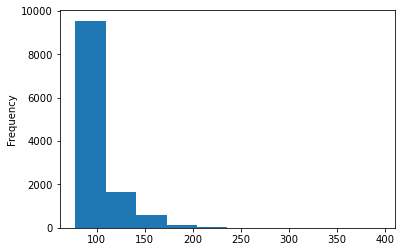

In [64]:
data[data['isFraud']==True]['accountAge'].plot(kind='hist')

In [65]:
data['accountAge_q'] = pd.qcut(data['accountAge'],q=4,
                              labels=["q1", "q2", "q3",'q4'])

In [66]:
data['accountAge'].describe()

count    749485.000000
mean        100.763701
std          22.640207
min          77.888939
25%          85.806966
50%          93.757848
75%         107.951158
max         394.182908
Name: accountAge, dtype: float64

In [67]:
#data.drop(['customerId','cardCVV', 'enteredCVV', 'cardLast4Digits','currentExpDate',
#'creditLimit','transactionDateTime','dateOfLastAddressChange','accountOpenDate'],axis=1,inplace=True)

In [68]:
data.head()

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,multiswap,reversed,cvvmatch,creditLimit_q,transactionAmount_q,100%creditAvailable,transactionMonth,transactionYear,transactionDay,transactionHour,sameAcqMerchantCountry,addressEverChange,accountAge,accountAge_q
0,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,0,0,0,0,0,1,q1,q4,1,8,2016,13,14,1,0,87.482565,q2
1,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,1,0,0,0,0,1,q1,q3,1,10,2016,11,5,1,0,87.482565,q2
2,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0,0,0,1,q1,q1,1,11,2016,8,9,1,0,87.482565,q2
3,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0,0,0,1,q1,q1,1,12,2016,10,2,1,0,87.482565,q2
4,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,1,0,0,0,0,1,q1,q3,1,3,2016,24,21,1,0,82.718607,q1


In [69]:
dummies = pd.get_dummies(data['transactionType'])
dummies.head()

,ADDRESS_VERIFICATION,PURCHASE
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [70]:
data['PURCHASE']=dummies['PURCHASE']

In [71]:
data.head()

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,multiswap,reversed,cvvmatch,creditLimit_q,transactionAmount_q,100%creditAvailable,transactionMonth,transactionYear,transactionDay,transactionHour,sameAcqMerchantCountry,addressEverChange,accountAge,accountAge_q,PURCHASE
0,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,0,0,0,0,0,1,q1,q4,1,8,2016,13,14,1,0,87.482565,q2,1
1,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,1,0,0,0,0,1,q1,q3,1,10,2016,11,5,1,0,87.482565,q2,1
2,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0,0,0,1,q1,q1,1,11,2016,8,9,1,0,87.482565,q2,1
3,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0,0,0,1,q1,q1,1,12,2016,10,2,1,0,87.482565,q2,1
4,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,1,0,0,0,0,1,q1,q3,1,3,2016,24,21,1,0,82.718607,q1,1


In [72]:
dummies = pd.get_dummies(data[['merchantCategoryCode','creditLimit_q','transactionAmount_q','accountAge_q']])
dummies.columns

Index(['merchantCategoryCode_airline', 'merchantCategoryCode_auto',
       'merchantCategoryCode_cable/phone',
       'merchantCategoryCode_entertainment', 'merchantCategoryCode_fastfood',
       'merchantCategoryCode_food', 'merchantCategoryCode_food_delivery',
       'merchantCategoryCode_fuel', 'merchantCategoryCode_furniture',
       'merchantCategoryCode_gym', 'merchantCategoryCode_health',
       'merchantCategoryCode_hotels', 'merchantCategoryCode_mobileapps',
       'merchantCategoryCode_online_gifts',
       'merchantCategoryCode_online_retail',
       'merchantCategoryCode_online_subscriptions',
       'merchantCategoryCode_personal care', 'merchantCategoryCode_rideshare',
       'merchantCategoryCode_subscriptions', 'creditLimit_q_q1',
       'creditLimit_q_q2', 'creditLimit_q_q3', 'creditLimit_q_q4',
       'transactionAmount_q_q1', 'transactionAmount_q_q2',
       'transactionAmount_q_q3', 'transactionAmount_q_q4',
       'transactionAmount_q_q5', 'transactionAmount_q_q6',

In [73]:
data[dummies.columns] = dummies[dummies.columns]

In [74]:
data.head()

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,multiswap,reversed,cvvmatch,creditLimit_q,transactionAmount_q,100%creditAvailable,transactionMonth,transactionYear,transactionDay,transactionHour,sameAcqMerchantCountry,addressEverChange,accountAge,accountAge_q,PURCHASE,merchantCategoryCode_airline,merchantCategoryCode_auto,merchantCategoryCode_cable/phone,merchantCategoryCode_entertainment,merchantCategoryCode_fastfood,merchantCategoryCode_food,merchantCategoryCode_food_delivery,merchantCategoryCode_fuel,merchantCategoryCode_furniture,merchantCategoryCode_gym,merchantCategoryCode_health,merchantCategoryCode_hotels,merchantCategoryCode_mobileapps,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions,creditLimit_q_q1,creditLimit_q_q2,creditLimit_q_q3,creditLimit_q_q4,transactionAmount_q_q1,transactionAmount_q_q2,transactionAmount_q_q3,transactionAmount_q_q4,transactionAmount_q_q5,transactionAmount_q_q6,accountAge_q_q1,accountAge_q_q2,accountAge_q_q3,accountAge_q_q4
0,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,0,0,0,0,0,1,q1,q4,1,8,2016,13,14,1,0,87.482565,q2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
1,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,1,0,0,0,0,1,q1,q3,1,10,2016,11,5,1,0,87.482565,q2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0
2,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0,0,0,1,q1,q1,1,11,2016,8,9,1,0,87.482565,q2,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
3,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0,0,0,1,q1,q1,1,12,2016,10,2,1,0,87.482565,q2,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
4,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,1,0,0,0,0,1,q1,q3,1,3,2016,24,21,1,0,82.718607,q1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0


In [85]:
data.drop(['customerId','cardCVV', 'enteredCVV', 'cardLast4Digits','currentExpDate','creditLimit',
           'transactionDateTime','dateOfLastAddressChange','accountOpenDate','merchantName','merchantCategoryCode',
          'acqCountry','merchantCountryCode','transactionType','creditLimit_q','transactionAmount_q',
           'accountAge_q'],axis=1,inplace=True)

In [86]:
len(data),len(data.columns)

(749485, 53)

In [87]:
y=data['isFraud']
X=data.drop(['isFraud'],axis=1)

In [93]:
X.columns

Index(['availableMoney', 'transactionAmount', 'posEntryMode',
       'posConditionCode', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'multiswap', 'reversed', 'cvvmatch',
       '100%creditAvailable', 'transactionMonth', 'transactionYear',
       'transactionDay', 'transactionHour', 'sameAcqMerchantCountry',
       'addressEverChange', 'accountAge', 'PURCHASE',
       'merchantCategoryCode_airline', 'merchantCategoryCode_auto',
       'merchantCategoryCode_cable/phone',
       'merchantCategoryCode_entertainment', 'merchantCategoryCode_fastfood',
       'merchantCategoryCode_food', 'merchantCategoryCode_food_delivery',
       'merchantCategoryCode_fuel', 'merchantCategoryCode_furniture',
       'merchantCategoryCode_gym', 'merchantCategoryCode_health',
       'merchantCategoryCode_hotels', 'merchantCategoryCode_mobileapps',
       'merchantCategoryCode_online_gifts',
       'merchantCategoryCode_online_retail',
       'merchantCategoryCode_online_subscriptions',


In [94]:
X.drop(['availableMoney','transactionAmount','posEntryMode','posConditionCode','currentBalance','transactionMonth','transactionYear',
        'transactionDay','transactionHour','accountAge'],axis=1,inplace=True)

In [95]:
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
x_new, y_new = rus.fit_resample(X, y)

In [96]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, test_size=0.3, random_state=42)

In [102]:
clf = LogisticRegression(random_state=0,solver='saga').fit(X_train, y_train)

In [103]:
clf.score(X_test,y_test )

0.6613218070273285